1) تأكيد عدم وجود تكرارات داخل CLEAN_DIR (داخل الكلاس وعلى مستوى كل الداتا)

In [1]:
from pathlib import Path
import hashlib, json
from tqdm import tqdm

CLEAN_DIR = Path("./ArASL_Cleaned")
IMG_EXTS  = {".png", ".jpg", ".jpeg", ".bmp"}

def is_img(p): return p.suffix.lower() in IMG_EXTS

def md5_of_file(path, chunk=1<<20):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for ch in iter(lambda: f.read(chunk), b""):
            h.update(ch)
    return h.hexdigest()

# --- per-class duplicates ---
dups_per_class = {}
for c in sorted([d for d in CLEAN_DIR.iterdir() if d.is_dir()], key=lambda p: p.name):
    seen = {}
    for p in tqdm([x for x in c.iterdir() if is_img(x)], desc=f"per-class {c.name}"):
        h = md5_of_file(p)
        if h in seen:
            dups_per_class.setdefault(c.name, []).append(str(p))
        else:
            seen[h] = str(p)

# --- global duplicates (بين الكلاسات) ---
seen_global = {}
dups_global  = []
for c in sorted([d for d in CLEAN_DIR.iterdir() if d.is_dir()], key=lambda p: p.name):
    for p in [x for x in c.iterdir() if is_img(x)]:
        h = md5_of_file(p)
        if h in seen_global and Path(seen_global[h]).parent.name != c.name:
            dups_global.append((seen_global[h], str(p)))
        else:
            seen_global[h] = str(p)

print("[CHECK] per-class duplicates total:", sum(len(v) for v in dups_per_class.values()))
print("[CHECK] cross-class duplicates total:", len(dups_global))

# احفظ تقارير للتوثيق
Path("./clean_logs").mkdir(exist_ok=True)
json.dump(dups_per_class, open("./clean_logs/check_per_class_dups.json","w"), indent=2, ensure_ascii=False)
json.dump(dups_global,  open("./clean_logs/check_cross_class_dups.json","w"), indent=2, ensure_ascii=False)

per-class zay: 100%|██████████| 1186/1186 [00:00<00:00, 15621.64it/s]


[CHECK] per-class duplicates total: 2
[CHECK] cross-class duplicates total: 43


2) تأكيد عدم تسريب بين الـ splits (نفس الصورة ظهرت في train/val/test)

In [2]:
from pathlib import Path
import hashlib

SPLIT_DIR = Path("./ArASL_Split")
IMG_EXTS  = {".png", ".jpg", ".jpeg", ".bmp"}

def is_img(p): return p.suffix.lower() in IMG_EXTS
def md5_of_file(path, chunk=1<<20):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for ch in iter(lambda: f.read(chunk), b""):
            h.update(ch)
    return h.hexdigest()

def hash_set(root):
    hs = set()
    for p in root.rglob("*"):
        if p.is_file() and is_img(p):
            try: hs.add(md5_of_file(p))
            except: pass
    return hs

train_h = hash_set(SPLIT_DIR/"train")
val_h   = hash_set(SPLIT_DIR/"val")
test_h  = hash_set(SPLIT_DIR/"test")

print("[LEAK] train ∩ val :", len(train_h & val_h))
print("[LEAK] train ∩ test:", len(train_h & test_h))
print("[LEAK] val   ∩ test:", len(val_h & test_h))

[LEAK] train ∩ val : 8
[LEAK] train ∩ test: 7
[LEAK] val   ∩ test: 0


3) تأكيد المقاس والقناة (64×64، رمادي) في CLEAN_DIR

In [3]:
import cv2
from pathlib import Path

CLEAN_DIR = Path("./ArASL_Cleaned")
bad_shapes = []
bad_modes  = []

for p in CLEAN_DIR.rglob("*.png"):
    im = cv2.imread(str(p), cv2.IMREAD_UNCHANGED)   # نقرأ كما هو
    if im is None:
        continue
    h, w = im.shape[:2]
    if (w, h) != (64, 64):          # مقاس مختلف
        bad_shapes.append(str(p))
    # لو ثلاث قنوات نعدّها مخالفة لأن هدفنا رمادي
    if im.ndim == 3 and im.shape[2] != 1:
        bad_modes.append(str(p))

print("[CHECK] non-64x64 images:", len(bad_shapes))
print("[CHECK] non-grayscale images:", len(bad_modes))

[CHECK] non-64x64 images: 0
[CHECK] non-grayscale images: 0


4) تأكيد الموازنة داخل train (وصلنا للهدف أو قريب منه) + توزيع val/test

In [4]:
import pandas as pd
from pathlib import Path

SPLIT_DIR = Path("./ArASL_Split")
IMG_EXTS  = {".png",".jpg",".jpeg",".bmp"}
TARGET_PER_CLASS = 1500  # عدّلي لو اخترتِ هدف آخر

def is_img(p): return p.suffix.lower() in IMG_EXTS

def count_split(split):
    rows=[]
    root = SPLIT_DIR / split
    for c in sorted([d for d in root.iterdir() if d.is_dir()], key=lambda p:p.name):
        n = sum(1 for p in c.iterdir() if is_img(p))
        rows.append({"class": c.name, "count": n})
    return pd.DataFrame(rows).sort_values("class").reset_index(drop=True)

df_tr = count_split("train")
df_va = count_split("val")
df_te = count_split("test")

print("train total:", int(df_tr["count"].sum()))
print("val   total:", int(df_va["count"].sum()))
print("test  total:", int(df_te["count"].sum()))

# فحص الموازنة (train)
too_low  = df_tr[df_tr["count"] < TARGET_PER_CLASS]
too_high = df_tr[df_tr["count"] > TARGET_PER_CLASS]
print(f"[BALANCE] train < target ({TARGET_PER_CLASS}):", len(too_low))
print(f"[BALANCE] train > target ({TARGET_PER_CLASS}):", len(too_high))

# تأكيد النِسَب في val/test لكل كلاس (تقريبًا 10%/10%)
chk = pd.concat([
    df_tr.assign(split="train"),
    df_va.assign(split="val"),
    df_te.assign(split="test"),
])
pv = chk.pivot(index="class", columns="split", values="count").fillna(0)
pv["total"]  = pv.sum(axis=1)
pv["train%"] = (pv["train"]/pv["total"]*100).round(1)
pv["val%"]   = (pv["val"]/pv["total"]*100).round(1)
pv["test%"]  = (pv["test"]/pv["total"]*100).round(1)
display(pv[["train%","val%","test%"]].head(10))

train total: 48038
val   total: 4842
test  total: 4842
[BALANCE] train < target (1500): 0
[BALANCE] train > target (1500): 1


split,train%,val%,test%
class,,,
ain,80.0,10.0,10.0
al,84.8,7.6,7.6
aleff,83.6,8.2,8.2
bb,82.4,8.8,8.8
dal,83.8,8.0,8.1
dha,82.9,8.6,8.6
dhad,83.5,8.2,8.3
fa,80.9,9.6,9.5
gaaf,83.2,8.4,8.4


5) (اختياري) رسم سريع يوضّح توازن train بعد الـ augmentation

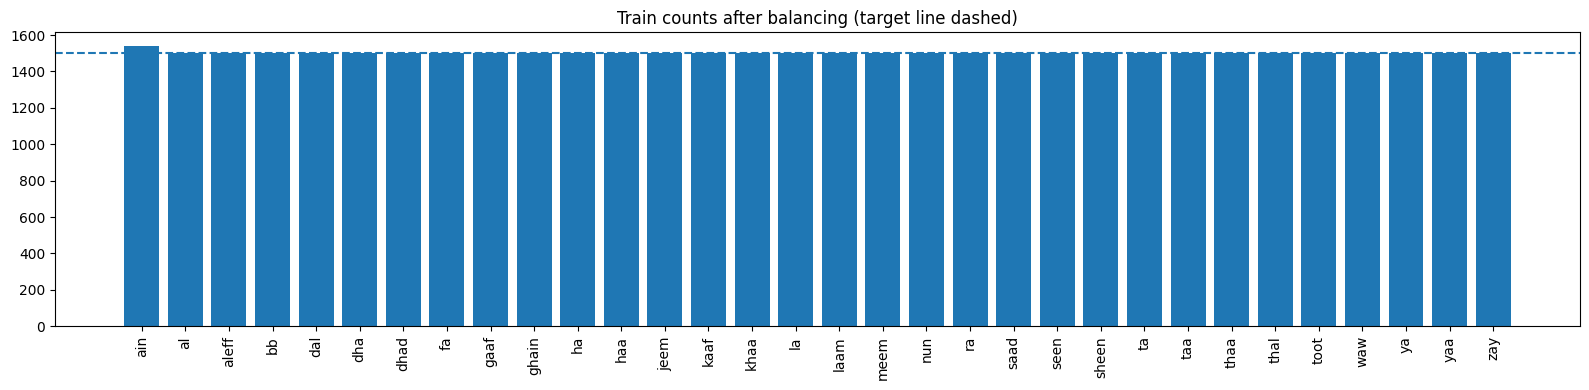

In [5]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(df_tr))
plt.figure(figsize=(16,4))
plt.bar(x, df_tr["count"].values)
plt.xticks(x, df_tr["class"].tolist(), rotation=90)
plt.axhline(TARGET_PER_CLASS, linestyle="--")
plt.title("Train counts after balancing (target line dashed)")
plt.tight_layout(); plt.show()